# **Cricket Match Winner Prediction Model**

# **Importing the required libraries**

In [363]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# **Loading the datasets**

In [364]:
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

In [365]:
match.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [366]:
match.shape

(756, 18)

In [367]:
delivery.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


# **Data Preperation**

In [368]:
total_score_df = delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index()

In [369]:
total_score_df = total_score_df[total_score_df['inning'] == 1]

In [370]:
total_score_df

,match_id,inning,total_runs
0,1,1,207
2,2,1,184
4,3,1,183
6,4,1,163
8,5,1,157
...,...,...,...
1518,11347,1,143
1520,11412,1,136
1522,11413,1,171
1524,11414,1,155


In [371]:
match_df = match.merge(total_score_df[['match_id','total_runs']],left_on='id',right_on='match_id')

In [372]:
match_df

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,match_id,total_runs
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,207
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,184
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN,3,183
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,4,163
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,IPL-2019,Mumbai,05-05-2019,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi,11347,143
752,11412,IPL-2019,Chennai,07-05-2019,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould,11412,136
753,11413,IPL-2019,Visakhapatnam,08-05-2019,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN,11413,171
754,11414,IPL-2019,Visakhapatnam,10-05-2019,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin,11414,155


In [373]:
match_df['team1'].unique()

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Delhi Capitals'], dtype=object)

In [374]:
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]

In [375]:
match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

In [376]:
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

In [377]:
match_df.shape

(641, 20)

In [378]:
match_df = match_df[match_df['dl_applied'] == 0]

In [379]:
match_df = match_df[['match_id','city','winner','total_runs']]

In [380]:
delivery_df = match_df.merge(delivery,on='match_id')

In [381]:
delivery_df = delivery_df[delivery_df['inning'] == 2]

In [382]:
delivery_df

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,0,0,1,0,1,NaN,NaN,NaN
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,0,0,2,0,2,NaN,NaN,NaN
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,0,0,4,0,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,0,0,1,0,1,NaN,NaN,NaN
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,0,0,2,0,2,NaN,NaN,NaN
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,0,0,1,0,1,SR Watson,run out,KH Pandya
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,0,0,2,0,2,NaN,NaN,NaN


In [383]:
# Convert 'total_runs_y' to numeric, forcing errors to NaN
delivery_df['total_runs_y'] = pd.to_numeric(delivery_df['total_runs_y'], errors='coerce')

# Fill NaN values with 0 if necessary
delivery_df['total_runs_y'].fillna(0, inplace=True)

# Now apply the cumulative sum
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()


C:\Users\visha\AppData\Local\Temp\ipykernel_19072\1989287729.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  delivery_df['total_runs_y'].fillna(0, inplace=True)


In [384]:
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']

In [385]:
delivery_df['balls_left'] = 126 - (delivery_df['over']*6 + delivery_df['ball'])

In [386]:
delivery_df

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,1,0,1,NaN,NaN,NaN,1,206,119
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,206,118
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,206,117
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,2,0,2,NaN,NaN,NaN,3,204,116
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,4,0,4,NaN,NaN,NaN,7,200,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,1,0,1,NaN,NaN,NaN,152,0,4
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,2,0,2,NaN,NaN,NaN,154,-2,3
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,1,0,1,SR Watson,run out,KH Pandya,155,-3,2
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,2,0,2,NaN,NaN,NaN,157,-5,1


In [387]:
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x:x if x == "0" else "1")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype('int')
# Convert 'player_dismissed' to numeric, where "0" stays as 0 and any non-0 values are treated as 1
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x: 0 if x == "0" else 1).astype(int)

# Now compute the cumulative sum of player dismissals per match
delivery_df['wickets'] = delivery_df.groupby('match_id')['player_dismissed'].cumsum()

# Calculate the remaining wickets (10 - total wickets)
delivery_df['wickets_remaining'] = 10 - delivery_df['wickets']

delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets,wickets_remaining
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,1,1,NaN,NaN,1,206,119,1,9
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,1,NaN,NaN,1,206,118,2,8
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,1,NaN,NaN,1,206,117,3,7
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,2,1,NaN,NaN,3,204,116,4,6
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,4,1,NaN,NaN,7,200,115,5,5


In [388]:
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets,wickets_remaining
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,1,1,NaN,NaN,1,206,119,1,9
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,1,NaN,NaN,1,206,118,2,8
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,1,NaN,NaN,1,206,117,3,7
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,2,1,NaN,NaN,3,204,116,4,6
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,4,1,NaN,NaN,7,200,115,5,5


In [389]:
# crr = runs/overs
delivery_df['crr'] = (delivery_df['current_score']*6)/(120 - delivery_df['balls_left'])

In [390]:
delivery_df['rrr'] = (delivery_df['runs_left']*6)/delivery_df['balls_left']

In [391]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

In [392]:
delivery_df['result'] = delivery_df.apply(result,axis=1)

In [393]:
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr','result']]

In [394]:
final_df = final_df.sample(final_df.shape[0])

In [395]:
final_df.sample()

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr,result
68575,Chennai Super Kings,Delhi Daredevils,Chennai,68,83,38,114,7.459459,4.915663,1


In [396]:
final_df.dropna(inplace=True)

In [397]:
final_df = final_df[final_df['balls_left'] != 0]

In [398]:
final_df.isnull().sum()

batting_team    0
bowling_team    0
city            0
runs_left       0
balls_left      0
wickets         0
total_runs_x    0
crr             0
rrr             0
result          0
dtype: int64

# **Data Visualisation**

<Axes: >

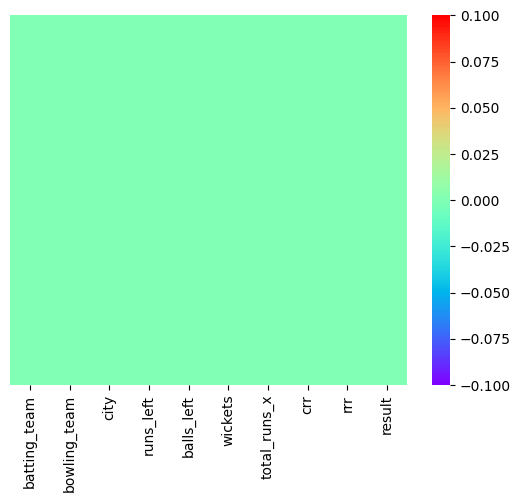

In [399]:
sns.heatmap(final_df.isnull(),cmap='rainbow',yticklabels=False)

**this means there are no null values in finaldf**

In [400]:
delivery_df['city'].unique()

array(['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
       'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
       'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
       'Sharjah', nan, 'Mohali', 'Bengaluru'], dtype=object)

In [401]:
teams

['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Delhi Capitals']

# **Splitting the data**

In [402]:
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [403]:
X_train

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr
137138,Sunrisers Hyderabad,Rajasthan Royals,Hyderabad,80,56,66,203,11.531250,8.571429
66453,Deccan Chargers,Chennai Super Kings,Chennai,27,10,111,160,7.254545,16.200000
140535,Kings XI Punjab,Sunrisers Hyderabad,Mohali,90,61,59,158,6.915254,8.852459
134965,Kolkata Knight Riders,Sunrisers Hyderabad,Kolkata,65,42,78,179,8.769231,9.285714
59700,Kolkata Knight Riders,Rajasthan Royals,Jaipur,70,30,94,164,6.266667,14.000000
...,...,...,...,...,...,...,...,...,...
70302,Delhi Daredevils,Royal Challengers Bangalore,Delhi,51,20,102,215,9.840000,15.300000
61571,Kolkata Knight Riders,Kings XI Punjab,Kolkata,86,85,37,134,8.228571,6.070588
38561,Kings XI Punjab,Kolkata Knight Riders,Chandigarh,160,96,26,183,5.750000,10.000000
51844,Kings XI Punjab,Delhi Daredevils,Delhi,88,34,88,231,9.976744,15.529412


In [404]:
trf = ColumnTransformer([
    ('trf',OneHotEncoder(drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')

In [405]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])

In [406]:
pipe.fit(X_train,y_train)

c:\Users\visha\OneDrive\Desktop\NxtCatch\environment\Lib\site-packages\sklearn\compose\_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first'),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [407]:
y_pred = pipe.predict(X_test)

In [408]:
pipe.predict_proba(X_test)[10]

array([0.70821231, 0.29178769])

In [409]:
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))
    

In [410]:
accuracy_score(y_test,y_pred)

0.7960613918284393

In [411]:
pickle.dump(pipe,open('model.pkl','wb'))